In [ ]:
## Libraries Install
# ! pip install chembl_webresource_client
# !pip install lazypredict
# !pip install scikit-learn
# !pip install numpy
# !pip install scipy
# !pip install matplotlib
# !pip install rdkit

In [ ]:
# ! wget https://raw.githubusercontent.com/dataprofessor/data/master/acetylcholinesterase_03_bioactivity_data_curated.csv
# ! wget https://raw.githubusercontent.com/dataprofessor/data/master/acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv
# ! wget https://github.com/dataprofessor/data/raw/master/acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv
# ! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
# ! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

In [ ]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client
import sys
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold

import lazypredict
from lazypredict.Supervised import LazyRegressor
import sklearn


In [63]:
df = pd.read_csv('/content/acetylcholinesterase_03_bioactivity_data_curated.csv')
print('Sample of chembl dataset')
df

Sample of chembl dataset


,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.00,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.00,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.00,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.00,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.00,active
...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,2440.00,intermediate
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,2540.00,intermediate
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,3810.00,intermediate
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,3460.00,intermediate


In [ ]:
df_no_smiles = df.drop(columns='canonical_smiles')
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,750.00,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.00,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.00,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.00,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.00,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
4690,CHEMBL4293155,2440.00,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...
4691,CHEMBL4282558,2540.00,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...
4692,CHEMBL4281727,3810.00,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...
4693,CHEMBL4292349,3460.00,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...


In [ ]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_combined = pd.concat([df,df_lipinski], axis=1)

In [ ]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [ ]:
df_combined.standard_value.describe()

count               4695.00
mean       3210931194533.58
std      118958001826580.66
min                    0.01
25%                  125.00
50%                 2246.00
75%                17530.00
max     5888436553555880.00
Name: standard_value, dtype: float64

In [ ]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [ ]:
df_norm = norm_value(df_combined)
df_final = pIC50(df_norm)
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.33,2.80,0.00,6.00,6.12
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.91,4.55,0.00,5.00,7.00
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.85,5.36,0.00,5.00,4.30
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.85,4.71,0.00,5.00,6.52
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.33,3.10,0.00,6.00,6.10
...,...,...,...,...,...,...,...,...
4675,CHEMBL4284261,CCN(C)Cc1cc(N)ccc1O.Cl.Cl,inactive,180.25,1.43,2.00,3.00,3.02
4676,CHEMBL4276921,CN(C)Cc1cc(N)ccc1O.Cl.Cl,inactive,166.22,1.04,2.00,3.00,2.81
4677,CHEMBL4292574,CNCc1cc(N)ccc1O.Cl.Cl,inactive,152.20,0.69,3.00,3.00,3.48
4685,CHEMBL4292766,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3F)CC2...,active,494.70,6.56,2.00,3.00,6.12


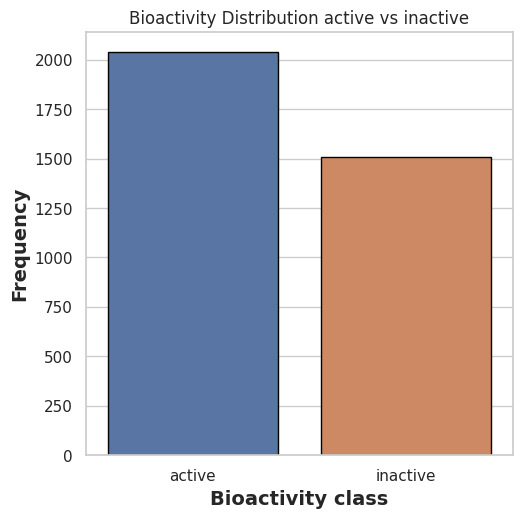

In [62]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Bioactivity Distribution active vs inactive')

plt.savefig('plot_bioactivity_class.pdf')

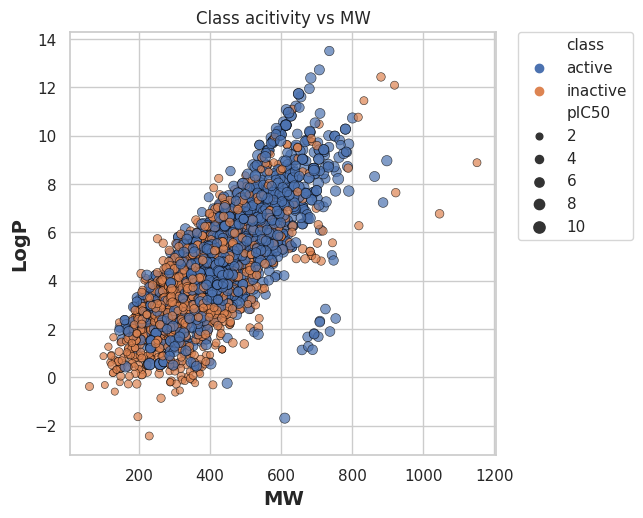

In [60]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('Class acitivity vs MW')
plt.savefig('plot_MW_vs_LogP.pdf')

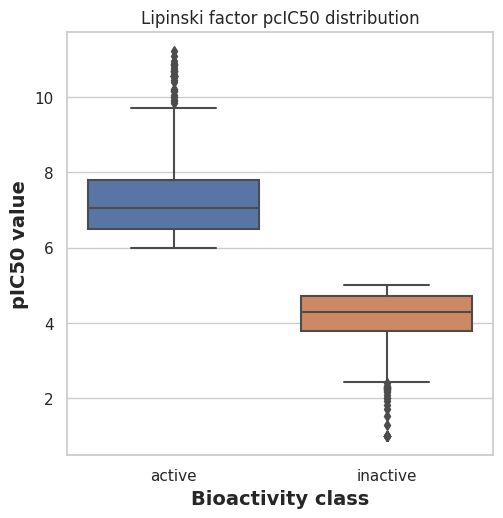

In [64]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')
plt.title('Lipinski factor pcIC50 distribution')

plt.savefig('plot_ic50.pdf')

In [ ]:
def mannwhitney(descriptor, verbose=False):

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

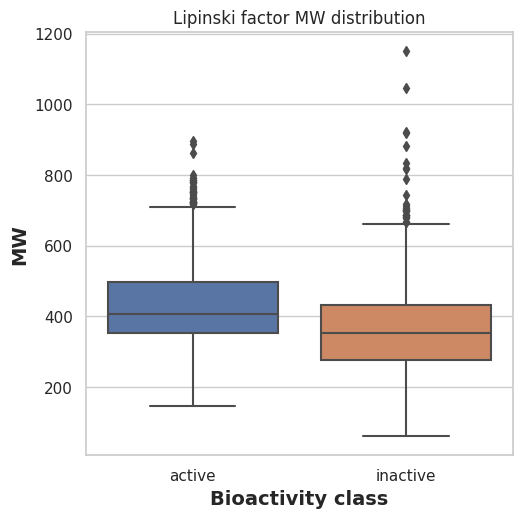

In [65]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')
plt.title('Lipinski factor MW distribution')

plt.savefig('plot_MW.pdf')

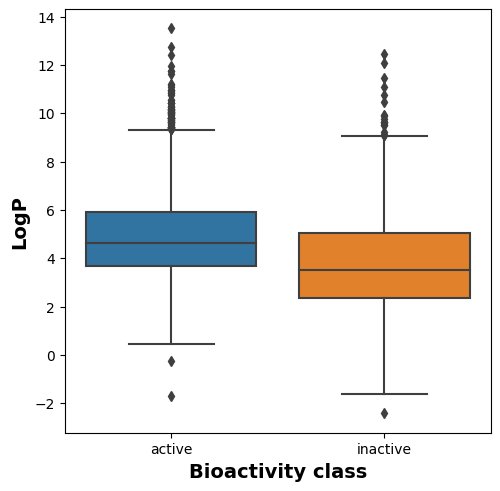

In [ ]:
mannwhitney('MW')
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.title('Lipinski factor LogP distribution')


plt.savefig('plot_LogP.pdf')

In [ ]:
df3 = pd.read_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
# ! unzip padel.zip
# ! bash padel.sh

In [ ]:
df3 = pd.read_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')
df3_X = pd.read_csv('descriptors_output.csv')
df3_X = df3_X.drop(columns=['Name'])
df3_Y = df3['pIC50']
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = pd.read_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')
X = df.drop('pIC50', axis=1)
Y = df.pIC50
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
print('R2 score', r2)
Y_pred = model.predict(X_test)

R2 score 0.5191947517686878


<function matplotlib.pyplot.show(close=None, block=None)>

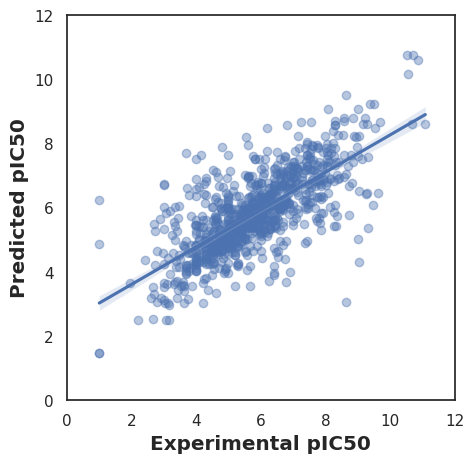

In [ ]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x = Y_test.values,y= Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show()

In [ ]:
df = pd.read_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')
X = df.drop('pIC50', axis=1)
Y = df.pIC50

selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None, regressors = [sklearn.tree._classes.DecisionTreeRegressor, 
                                                                                      sklearn.neural_network._multilayer_perceptron.MLPRegressor, 
         sklearn.linear_model._ridge.Ridge, 
         sklearn.svm._classes.LinearSVR, 
         sklearn.ensemble._weight_boosting.AdaBoostRegressor])

models_train,predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)

100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


In [ ]:
predictions_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,0.86,0.86,0.57,0.08
MLPRegressor,0.76,0.77,0.75,7.80
Ridge,0.31,0.33,1.27,0.06
LinearSVR,0.27,0.30,1.30,0.52
AdaBoostRegressor,0.20,0.23,1.36,0.66


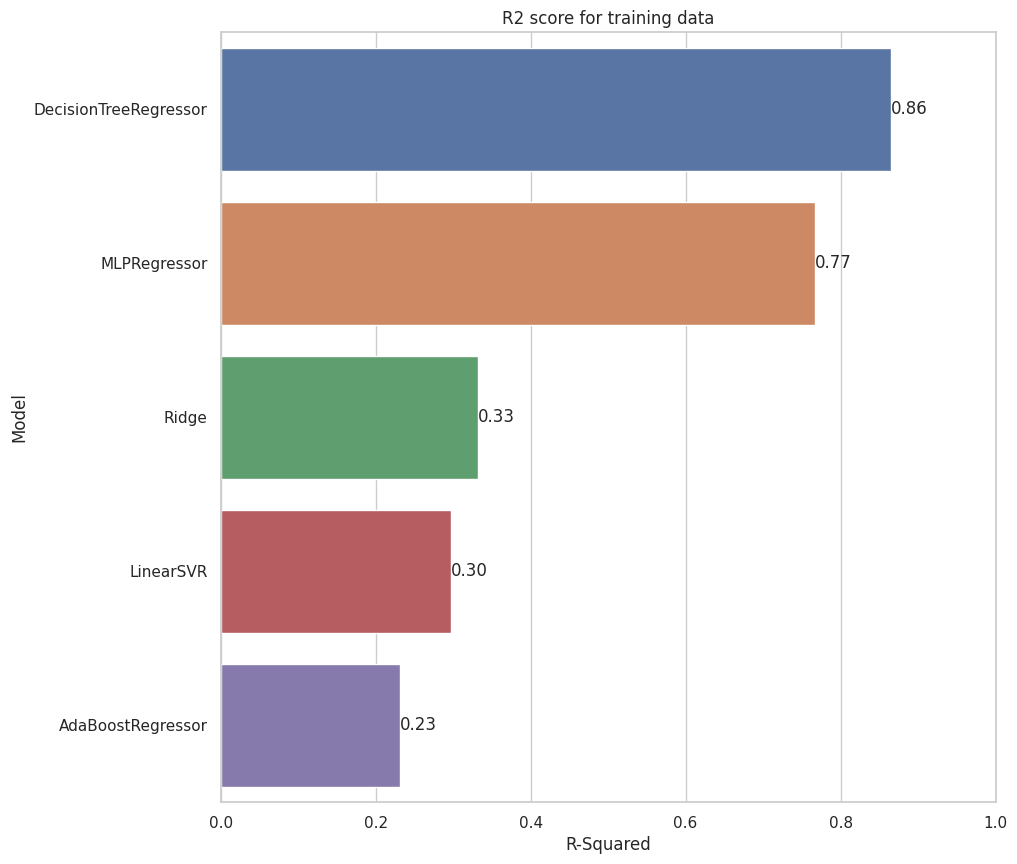

In [ ]:
plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title('R2 score for training data')

ax.set(xlim=(0, 1))
plt.show()

In [ ]:
models_test,predictions_test = clf.fit(X_test, X_test, Y_test, Y_test)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


In [ ]:
predictions_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,0.94,0.95,0.36,0.05
MLPRegressor,0.82,0.85,0.61,1.41
Ridge,0.33,0.43,1.17,0.03
LinearSVR,0.27,0.38,1.23,0.20
AdaBoostRegressor,0.15,0.28,1.32,0.23


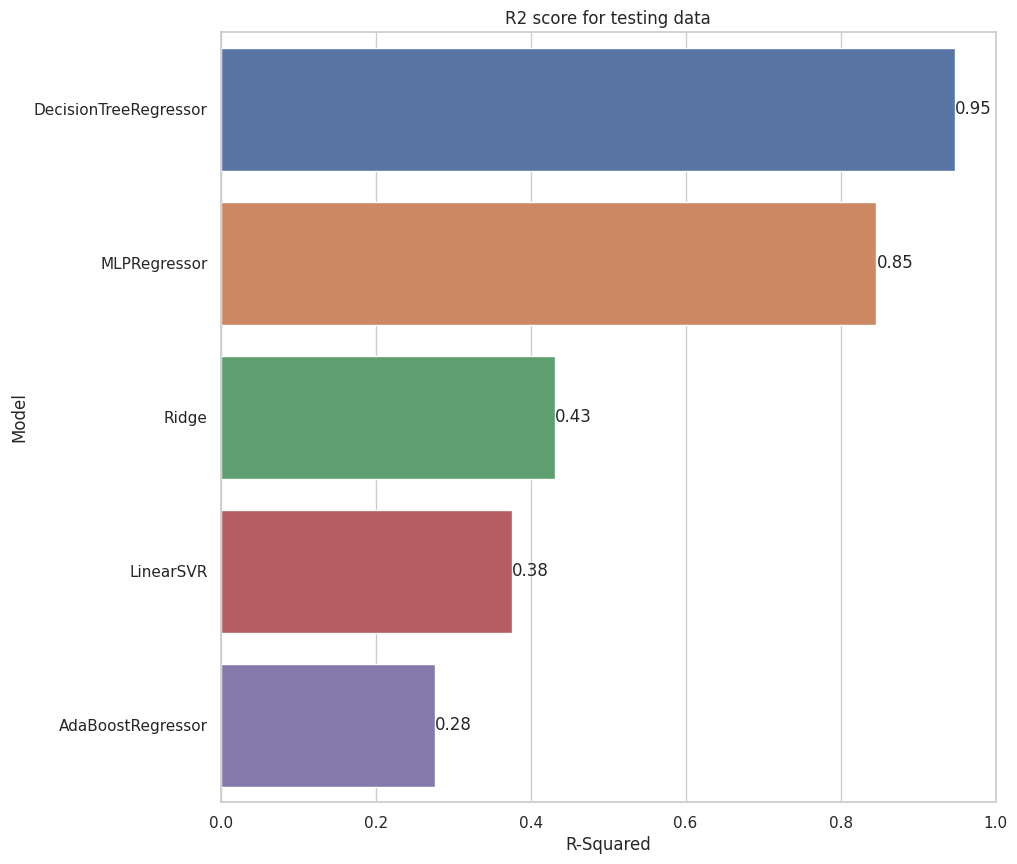

In [ ]:
plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_test.index, x="R-Squared", data=predictions_test)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title('R2 score for testing data')

ax.set(xlim=(0, 1))
plt.show()